In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

### **Loading The Dataset**

In [3]:
df = pd.read_csv('Data/train.csv', delimiter=',')

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### **Data Cleaning and Preprocessing**

In [6]:
shape_before = df.shape
print("Original Shape: ", shape_before)

Original Shape:  (891, 12)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [9]:
df.cov()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,66231.000000,-0.626966,-7.561798,138.696504,-16.325843,-0.342697,161.883369
Survived,-0.626966,0.236772,-0.137703,-0.551296,-0.018954,0.032017,6.221787
Pclass,-7.561798,-0.137703,0.699015,-4.496004,0.076599,0.012429,-22.830196
Age,138.696504,-0.551296,-4.496004,211.019125,-4.163334,-2.344191,73.849030
SibSp,-16.325843,-0.018954,0.076599,-4.163334,1.216043,0.368739,8.748734
Parch,-0.342697,0.032017,0.012429,-2.344191,0.368739,0.649728,8.661052
Fare,161.883369,6.221787,-22.830196,73.849030,8.748734,8.661052,2469.436846


### Checking for Null values

In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

> Features **Age**, **Cabin** and **Embarked** have missing values. But since, specially for **Cabin** and **Age**, this datapoints are large in number, so it is a good idea to first see their impact on passangers' survival before deciding what to do about them.

### Handling missing Values for **Age**, **Cabin** and **Embarked** Features

The features **Age**, **Cabin** and **Embarked** are subject of interest. But since dropping the missing values significantly affects the size of the dataset for features **Age** and **Cabin**, another option should be explored. 

#### **Age**

To figure out the right value to fillin the missing values in the **Age** feature, its relationship with features it is highly correlated is first explored. The **Pclass** feature is the target for this experiment.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

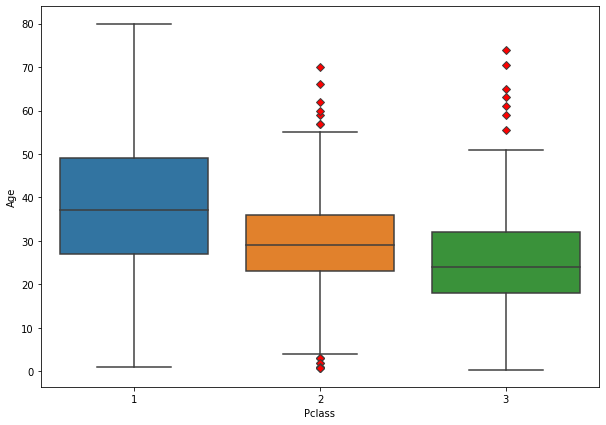

In [11]:
plt.figure(figsize=(10,7))
flier = dict(markerfacecolor='red', marker='D')
sns.boxplot(data=df, x="Pclass", y="Age", flierprops=flier)

From the plot above, it can be surmised that **Pclass** catagories are highly affected **age group**. So, one reasonable approach is to tailer to fillin the missing values to their Pclass category.Based on the categories, the missing values on the **Age** feature is filled with the respective median values.
* Choosing the median value is better for imputation in the case of outliers

In [12]:
median1 = df["Age"][df["Pclass"]==1].median()
median2 = df["Age"][df["Pclass"]==2].median()
median3 = df["Age"][df["Pclass"]==3].median()

In [13]:
median1, median2, median3

(37.0, 29.0, 24.0)

In [14]:
df["Age"] = df["Age"].fillna(0)
for i in range(df.shape[0]):
    if df.Age[i] == 0:
        if df["Pclass"][i] == 1:
            df.Age[i] = median1
        elif df["Pclass"][i] == 2:
            df.Age[i] = median2
        else:
            df.Age[i] = median3

/tmp/ipykernel_27731/2713734702.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Age[i] = median3
/tmp/ipykernel_27731/2713734702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Age[i] = median2
/tmp/ipykernel_27731/2713734702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Age[i] = median1


#### **Cabin**

To understand the extent to which the missing values on the **Cabin** feature impact passengers' survival, I will replace those missing values with **0**. Similarly I will replace the datapoints with values present with **1** to better assess the dynamic at play.

In [15]:
print("\nBefore filling the missing values:")
df.Cabin[:5]


Before filling the missing values:


0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [16]:
df["Cabin"] = df["Cabin"].fillna(0)
df["Cabin"] = df.Cabin.apply(lambda x: 1 if x != 0 else x)

In [17]:
print("\nAfter filling the missing values:")
df.Cabin[:5]


After filling the missing values:


0    0
1    1
2    0
3    1
4    0
Name: Cabin, dtype: int64

#### Plotting for Cabin versus Survival

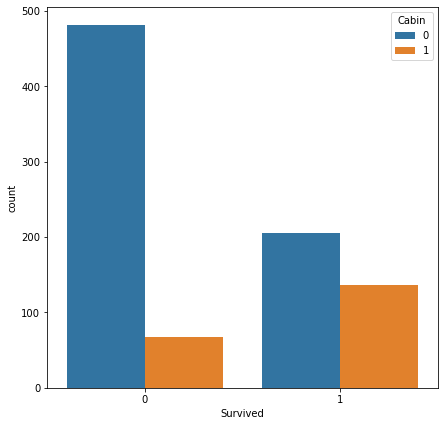

In [18]:
plt.figure(figsize=(7,7))
sns.countplot(data=df, x="Survived", hue="Cabin")
plt.show()

It can be derived from the plot that datapoints with missing values for the **Cabin** feature have major contributions to the target feature. Although some of the datapoints contribute to the death of passangers, the majority contribute to those who survived. Therefore, considering a value of **0** for the missing values in this feature is an acceptable risk.

#### **Embarked**

In the case of the feature **Embarked**, there are only two missing values. Therefore, removing the datapoints associated with those two missing values is the next logical step.

In [19]:
df = df.dropna()

In [20]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,1,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


In [21]:
shape_after = df.shape
shape_diff = shape_before[0] - shape_after[0]

In [22]:
print("Original Shape: ", shape_before, "\nShape after droping null values: ", shape_after)

Original Shape:  (891, 12) 
Shape after droping null values:  (889, 12)


In [23]:
print("Number of datapoints removed: ", shape_diff)

Number of datapoints removed:  2


The **Sex** feature should be binarized. To do that, first let's see how many genders there are.

In [24]:
print(df.Sex.unique())

['male' 'female']


There are only two genders, so the values **0** and **1** will be assigned in place of **male** and **female**, respectively.

In [25]:
df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "female" else 0)

/tmp/ipykernel_27731/2991096452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "female" else 0)


In [26]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,S
5,6,0,3,"Moran, Mr. James",0,24.0,0,0,330877,8.4583,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,1,S
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,0,C


Next, the **Embarked** feature will be subject to feature engineering. To do this, separate features are created and binarized to represent each embarkment. But since working out for the two embarkments also represents the third embarkment (when the two take the value 0), the **Embarked** feature is only re-engineering into two.

In [27]:
dummies = pd.get_dummies(df["Embarked"])
df["S"] = dummies["S"]
df["C"] = dummies["C"]
df.drop(columns="Embarked", inplace=True)

/tmp/ipykernel_27731/2076350083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["S"] = dummies["S"]
/tmp/ipykernel_27731/2076350083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C"] = dummies["C"]
/tmp/ipykernel_27731/2076350083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="Embarked",

In [28]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,1,0
5,6,0,3,"Moran, Mr. James",0,24.0,0,0,330877,8.4583,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,1,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,0,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,0,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,0,0,1


In [29]:
ticket_amount = len(df.Ticket.unique())
ticket_amount

680

In [30]:
df.shape[0]

889

In [31]:
non_unique_tickets = (df.shape[0]) - ticket_amount
non_unique_tickets

209

The number of unique tickets issued is 680. This tells us that there are 209 tickets that are not unique. Let's see if there is a relationship between whether is unique or not and passengers' survival. To do just that, tickets that are unique are going to be denoted by **1** and those that are not unique are going to be denoted by **0**.

In [32]:
df["Ticket"] = [1 if i is False else 0 for i in list(df['Ticket'].duplicated())]

/tmp/ipykernel_27731/2051379725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ticket"] = [1 if i is False else 0 for i in list(df['Ticket'].duplicated())]


In [33]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1,7.2500,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,1,71.2833,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,1,7.9250,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,1,53.1000,1,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,1,8.0500,0,1,0
5,6,0,3,"Moran, Mr. James",0,24.0,0,0,1,8.4583,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,1,51.8625,1,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,1,21.0750,0,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,1,11.1333,0,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,1,30.0708,0,0,1


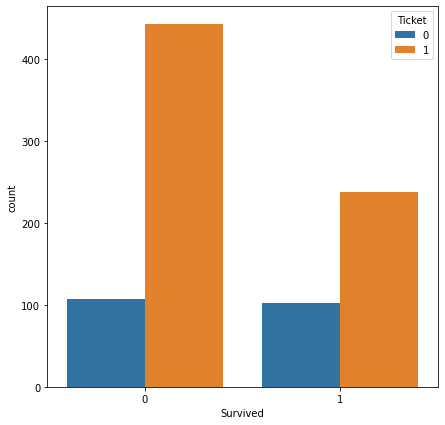

In [34]:
plt.figure(figsize=(7,7))
sns.countplot(data=df, x="Survived", hue="Ticket")
plt.show()

From the plot above, it can be surmised that passengers with tickets that are unique are more likely not to survive the calamity abroad the ship, while those with tickets that are not unique don't show a significant change in their survival.

The **Name** feature is not useful in predicting passengers' survival, so it should be removed from the data.

In [35]:
df.drop(columns="Name", inplace=True)

/tmp/ipykernel_27731/2763228117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="Name", inplace=True)


In [36]:
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
0,1,0,3,0,22.0,1,0,1,7.2500,0,1,0
1,2,1,1,1,38.0,1,0,1,71.2833,1,0,1
2,3,1,3,1,26.0,0,0,1,7.9250,0,1,0
3,4,1,1,1,35.0,1,0,1,53.1000,1,1,0
4,5,0,3,0,35.0,0,0,1,8.0500,0,1,0
5,6,0,3,0,24.0,0,0,1,8.4583,0,0,0
6,7,0,1,0,54.0,0,0,1,51.8625,1,1,0
7,8,0,3,0,2.0,3,1,1,21.0750,0,1,0
8,9,1,3,1,27.0,0,2,1,11.1333,0,1,0
9,10,1,2,1,14.0,1,0,1,30.0708,0,0,1


### **Data Analysis and Visualization**

In [37]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.350956,29.019314,0.524184,0.382452,0.764904,32.096681,0.227222,0.724409,0.188976
std,256.998173,0.486260,0.834700,0.477538,13.209814,1.103705,0.806761,0.424297,49.697504,0.419273,0.447063,0.391710
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.000000,7.895800,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,26.000000,0.000000,0.000000,1.000000,14.454200,0.000000,1.000000,0.000000
75%,668.000000,1.000000,3.000000,1.000000,36.500000,1.000000,0.000000,1.000000,31.000000,0.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,1.000000,512.329200,1.000000,1.000000,1.000000


In [38]:
df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
PassengerId,1.000000,-0.005028,-0.035330,-0.043136,0.033008,-0.057686,-0.001657,-0.234843,0.012703,0.020045,0.022269,-0.001208
Survived,-0.005028,1.000000,-0.335549,0.541585,-0.052051,-0.034040,0.083151,-0.120449,0.255290,0.313435,-0.151777,0.169966
Pclass,-0.035330,-0.335549,1.000000,-0.127741,-0.405549,0.081656,0.016824,0.114856,-0.548193,-0.723815,0.076466,-0.245733
Sex,-0.043136,0.541585,-0.127741,1.000000,-0.083730,0.116348,0.247508,-0.187024,0.179958,0.135589,-0.121405,0.084520
Age,0.033008,-0.052051,-0.405549,-0.083730,1.000000,-0.242807,-0.170089,0.134036,0.120938,0.271546,0.013598,0.042585
SibSp,-0.057686,-0.034040,0.081656,0.116348,-0.242807,1.000000,0.414542,-0.407468,0.160887,-0.038657,0.069438,-0.060074
Parch,-0.001657,0.083151,0.016824,0.247508,-0.170089,0.414542,1.000000,-0.395000,0.217532,0.039101,0.061512,-0.011588
Ticket,-0.234843,-0.120449,0.114856,-0.187024,0.134036,-0.407468,-0.395000,1.000000,-0.323425,-0.117177,0.008321,-0.057620
Fare,0.012703,0.255290,-0.548193,0.179958,0.120938,0.160887,0.217532,-0.323425,1.000000,0.480425,-0.163758,0.270731
Cabin,0.020045,0.313435,-0.723815,0.135589,0.271546,-0.038657,0.039101,-0.117177,0.480425,1.000000,-0.104121,0.211375


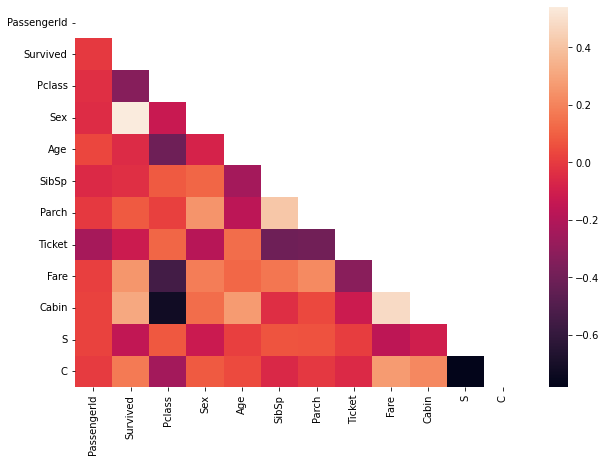

In [39]:
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot=False)
plt.show()

In [40]:
df.Survived.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [41]:
survival_count = [df.Survived.value_counts()[1], df.Survived.value_counts()[0]]
survival_count

[340, 549]

In [42]:
explode = [0.1, 0]
labels = ["Survived", "Died"]

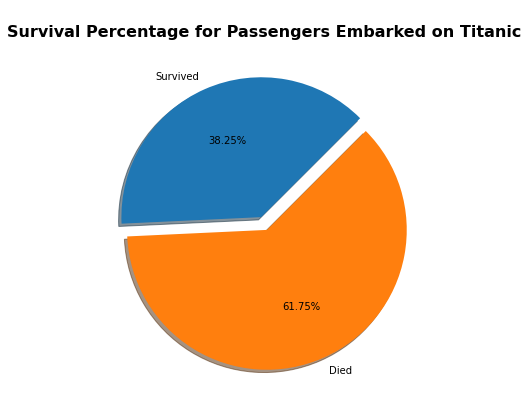

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(survival_count, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True,startangle=45)
ax.axis('equal')
ax.set_title("\nSurvival Percentage for Passengers Embarked on Titanic\n", fontsize=16, fontweight="bold")
plt.show()

#### Creating pairplot to plot multiple pairwise bivariate distributions in the dataset will give us more visual details

In [44]:
numeric_col = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'S', 'C', 'Survived']

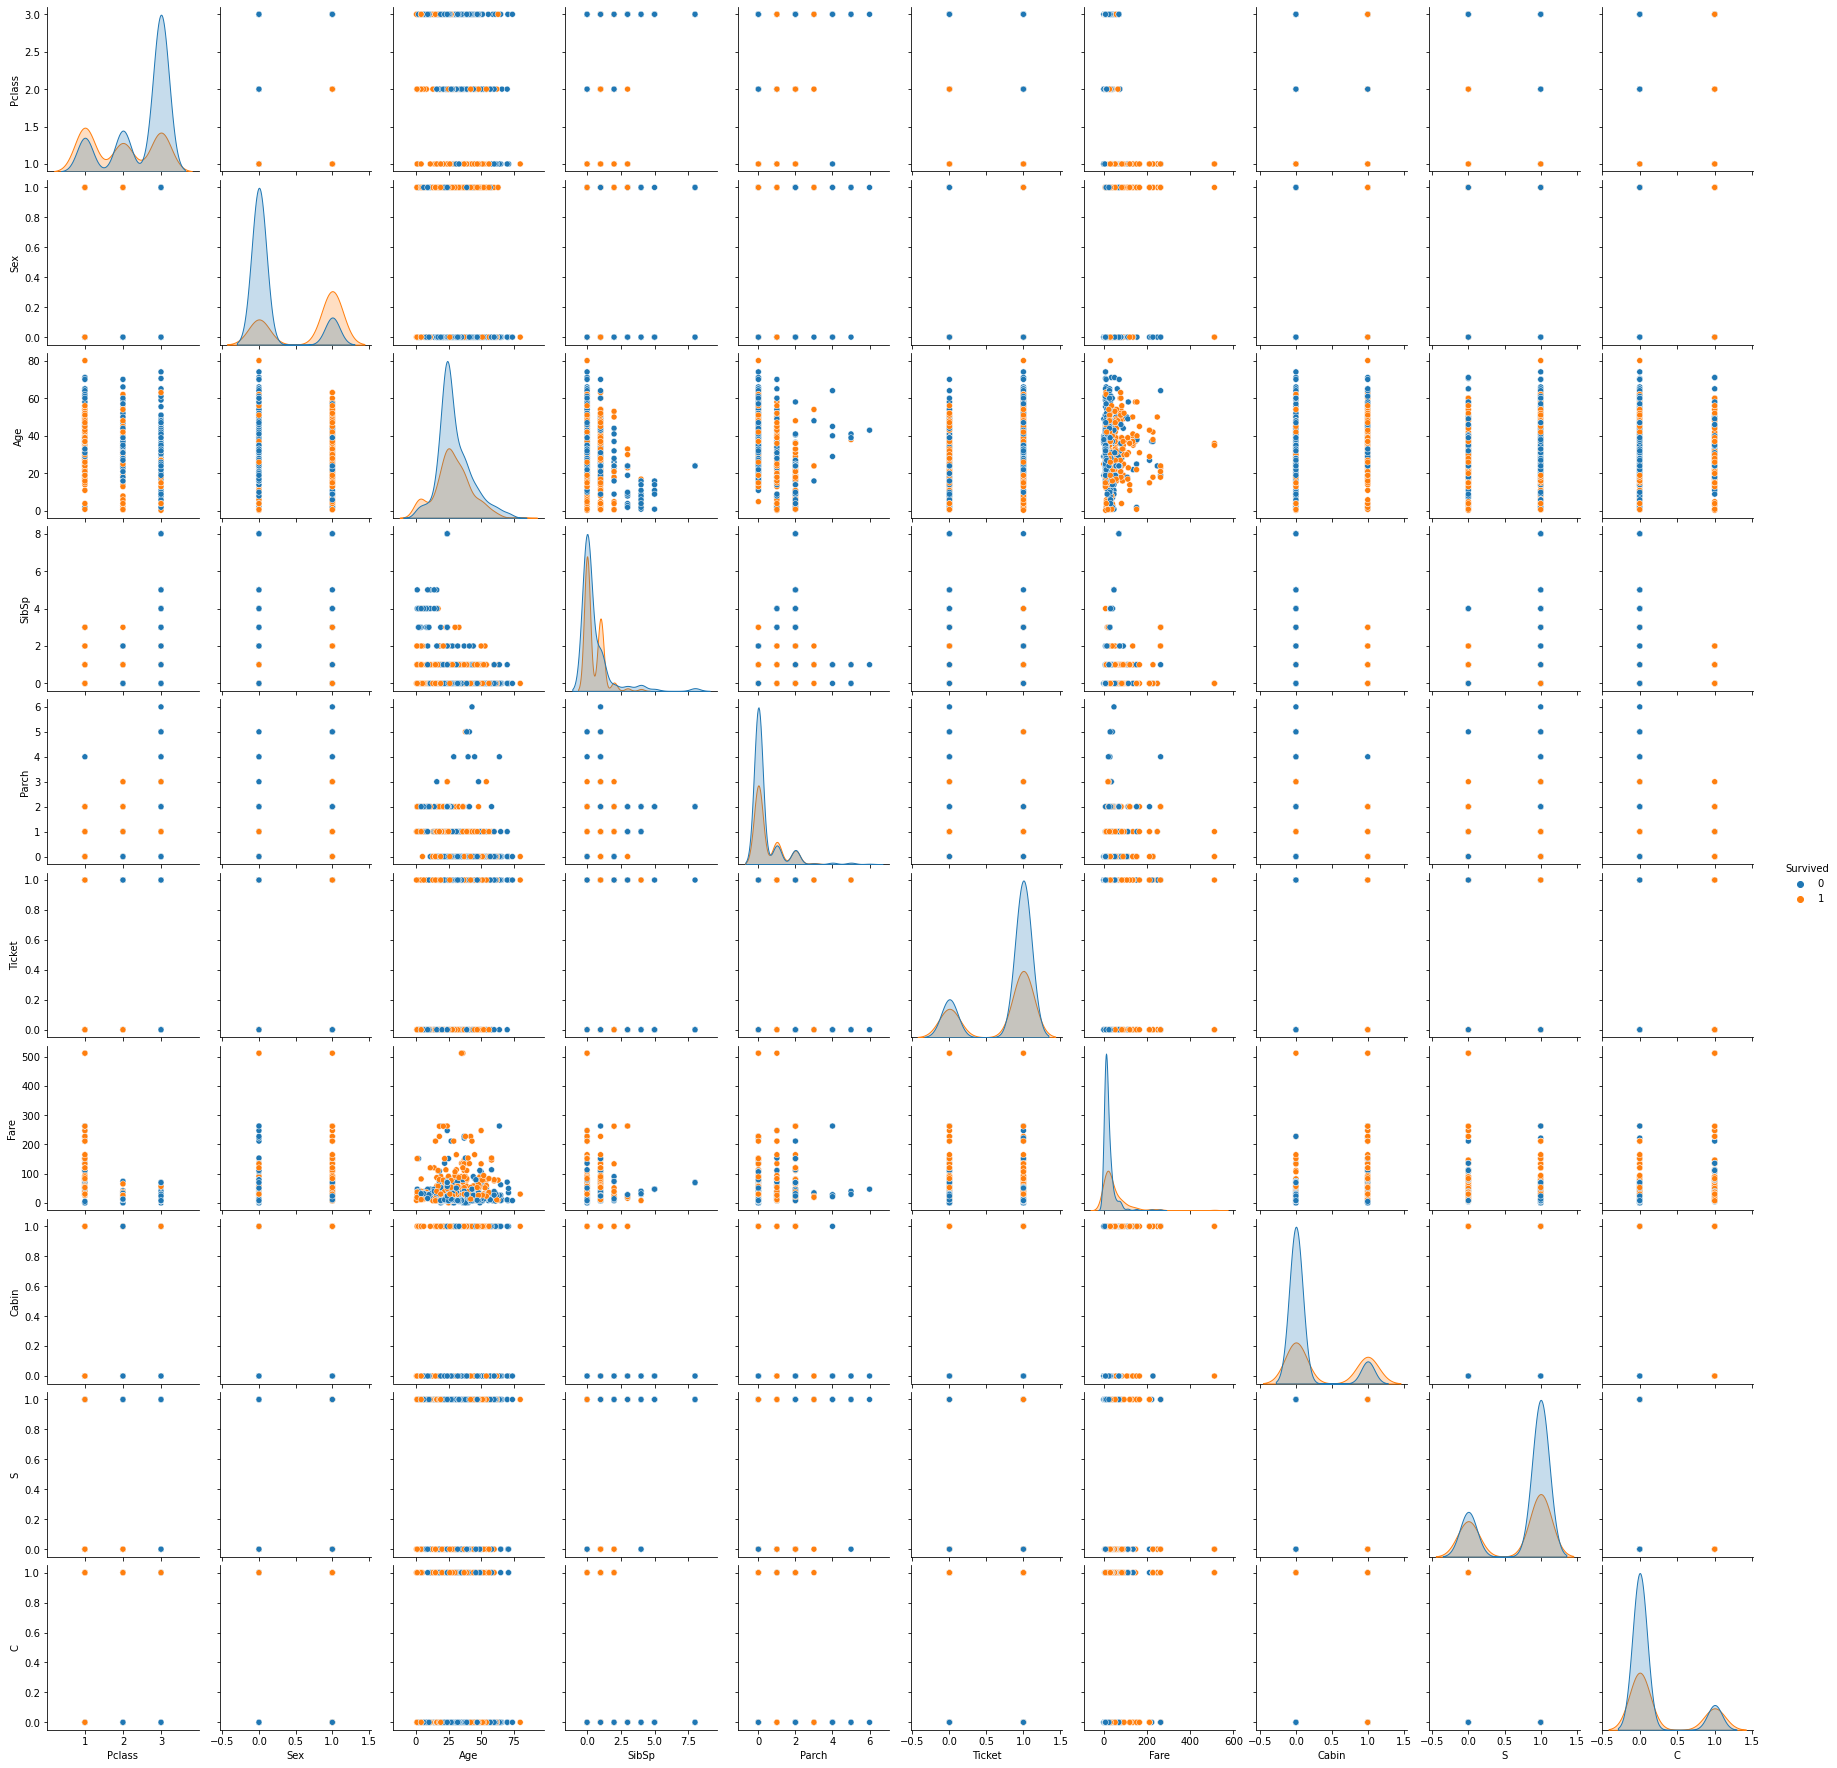

In [45]:
sns.pairplot(df[numeric_col], hue="Survived")
plt.show()

### **Training and Validation Sets Preparation**

In [46]:
X = df.drop(["Survived"], axis=1)
X.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,S,C
0,1,3,0,22.0,1,0,1,7.2500,0,1,0
1,2,1,1,38.0,1,0,1,71.2833,1,0,1
2,3,3,1,26.0,0,0,1,7.9250,0,1,0
3,4,1,1,35.0,1,0,1,53.1000,1,1,0
4,5,3,0,35.0,0,0,1,8.0500,0,1,0
5,6,3,0,24.0,0,0,1,8.4583,0,0,0
6,7,1,0,54.0,0,0,1,51.8625,1,1,0
7,8,3,0,2.0,3,1,1,21.0750,0,1,0
8,9,3,1,27.0,0,2,1,11.1333,0,1,0
9,10,2,1,14.0,1,0,1,30.0708,0,0,1


In [47]:
Y = df["Survived"].astype("int")
Y.head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

> 80% of the data will be dedicated for training while the remaining 20% will be used for validation

In [48]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state = 42)

Applying standardization to the data so it resembles more like a standard normally distributed data (resize the distribution of values so that the mean of the observed values is 0 and the standard deviation is 1) proves to be helpful for various machine learning models.

In [49]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

### **Fitting The Data to Models**

Defining object instances for the classification models

In [50]:
xgb = XGBClassifier()
knn = KNeighborsClassifier(n_neighbors=7)
dtr = DecisionTreeClassifier(random_state=32)
svc = SVC(kernel='linear', C=1.0)
rfr = RandomForestClassifier(random_state=40)

Estimating the average cross-validation score for each models

In [51]:
score_xgb = cross_val_score(xgb, x_train_scaled, y_train, cv=5).mean()
score_knn = cross_val_score(knn, x_train_scaled, y_train, cv=5).mean()
score_dtr = cross_val_score(dtr, x_train_scaled, y_train, cv=5).mean()
score_svc = cross_val_score(svc, x_train_scaled, y_train, cv=5).mean()
score_rfr = cross_val_score(rfr, x_train_scaled, y_train, cv=5).mean()

In [54]:
models = pd.DataFrame({
    "Model" : ["XG Boost", "KNeighborsClassifier", "DecisionTreeClassifier", "Support Vector Classification", "RandomForestClassifier"],
    "Average Score" : [score_xgb, score_knn, score_dtr, score_svc, score_rfr]
}).sort_values(by="Average Score", ascending=False).reset_index(drop=True)

In [55]:
models

,Model,Average Score
0,RandomForestClassifier,0.825588
1,XG Boost,0.808736
2,KNeighborsClassifier,0.801635
3,Support Vector Classification,0.779169
4,DecisionTreeClassifier,0.751098


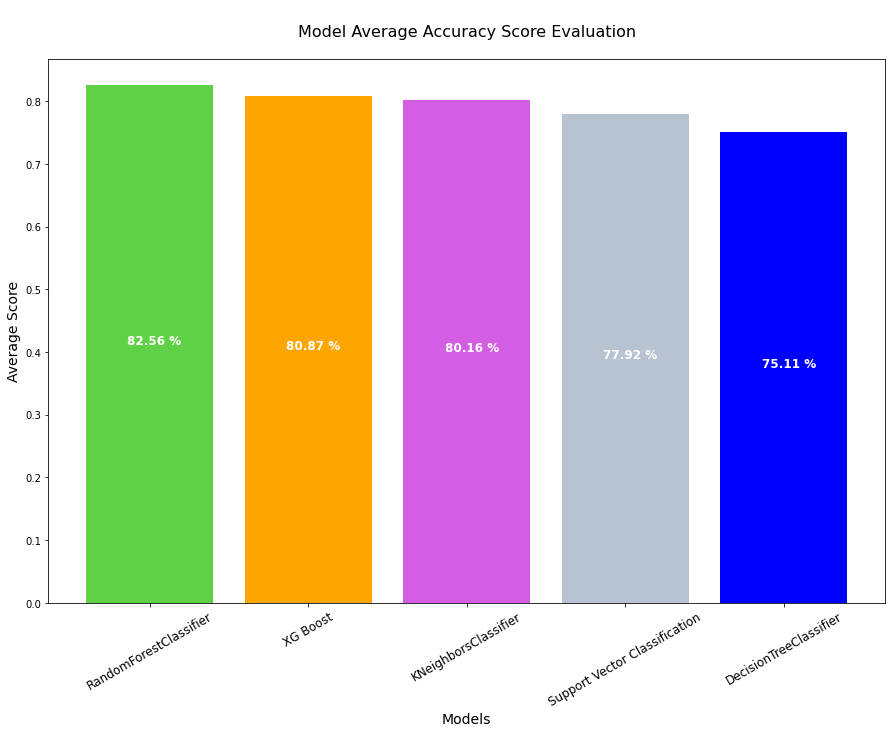

In [62]:
fig,ax = plt.subplots(figsize=(15,10))

colors = ['#60d147', '#FFA500', "#d35de3", '#B7C3D0', "#0000FF"]

plt.bar(models["Model"], models["Average Score"], color=colors)
plt.xticks(rotation=30, fontsize=12)

ax.set_title("\nModel Average Accuracy Score Evaluation\n", fontsize=16)
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Average Score", fontsize=14)

for k, i in enumerate(ax.patches):
        val = models["Average Score"][k]
    
        plt.text((i.get_xy()[0] + .26), (val/2),
        f"{round((val*100),2)} %", fontsize=12, fontweight='bold',
        color ='white', rotation=0)
        
plt.show()

In [63]:
best_model_name = models.loc[0][0]

In [64]:
best_model_name

'RandomForestClassifier'

### **Save The Best Performing Model**

To save the best performing model, first it is trained on the entire training dataset: **X** and **Y**.

In [65]:
x_scaled = scaler.fit_transform(X)

In [69]:
rfr.fit(x_scaled, Y)

RandomForestClassifier(random_state=40)

In [72]:
joblib.dump(rfr, best_model_name+'_saved_model.pkl')

['RandomForestClassifier_saved_model.pkl']

### **Loading The Saved Model and Applying The Testing Data**

In [73]:
saved_model = joblib.load(best_model_name+'_saved_model.pkl')

In [ ]:
test_pred = saved_model.predict(x_test_scaled)